# XRF Element Correlation Analysis
Pixel-level and cluster-specific correlations from µ-XRF maps.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import pearsonr, spearmanr
from sklearn.cluster import KMeans
from pathlib import Path
import h5py, warnings
import ipywidgets as widgets
from IPython.display import display, clear_output
warnings.filterwarnings("ignore")

In [2]:
# ---------- Config ----------
MAP_DIR = Path("maps")
PCA_DIR = Path("pca_results")
OUT_DIR = Path("xrf_correlation")
OUT_DIR.mkdir(exist_ok=True)
DPI = 150

# Elements to analyze (must match ROI names in HDF5)
ELEMENTS = ["Fe Ka", "Ca Ka", "K Ka", "Ti Ka", "Mn Ka", "S Ka", "Si Ka", "P Ka"]
SHORT = {e: e.replace(" Ka", "") for e in ELEMENTS}
ELEM_SHORT = [SHORT[e] for e in ELEMENTS]

# The 4 Figure 1 map files
FIG1_MAPS = {
    "striated_gt15_2":    "2x2_10um_striated_gt15_2_001.h5",
    "rectangles_gt15_1":  "2x2_10um_rectangles_gt15_1_001.h5",
    "flaky_nodule":       "2x2_10um_flaky_nodule_001.h5",
    "flaky_dark_gt15":    "1x1_10um_flaky_dark_gt15_001.h5",
}

CLUSTER_COLORS = {1: '#1f77b4', 2: '#ff7f0e', 3: '#2ca02c', 4: '#d62728', 5: '#9467bd'}
CLUSTER_LABELS = {1: 'Grp 1', 2: 'Grp 2', 3: 'Grp 3', 4: 'Grp 4', 5: 'Grp 5'}

In [3]:
# ---------- HDF5 helpers ----------
def get_roi_map(f, roi_name):
    names = [n.decode() if isinstance(n, bytes) else n for n in f["xrmmap/roimap/sum_name"][:]]
    if roi_name in names:
        idx = names.index(roi_name)
        return f["xrmmap/roimap/sum_cor"][:, 1:-1, idx].astype(float)
    return None

## 1. Load data

In [4]:
# Load cluster assignments
clusters_df = pd.read_csv(PCA_DIR / "cluster_assignments.csv")
cluster_lookup = dict(zip(clusters_df["spectrum"], clusters_df["cluster"]))

# All HDF5 map files
all_h5 = sorted([p for p in MAP_DIR.glob("*.h5") if "test_map" not in p.name])
print(f"Found {len(all_h5)} map files")

Found 15 map files


In [5]:
# Extract XANES point element intensities
all_point_data = []

for h5_path in all_h5:
    with h5py.File(h5_path, "r") as f:
        maps = {}
        for elem in ELEMENTS:
            m = get_roi_map(f, elem)
            if m is not None:
                maps[elem] = m

        if "Fe Ka" not in maps:
            continue

        areas = f.get("xrmmap/areas")
        if areas is None:
            continue

        for area_name in areas:
            spec_name = f"FeXANES_{area_name}.001"
            cluster_id = cluster_lookup.get(spec_name)
            if cluster_id is None:
                continue

            mask = areas[area_name][:]
            if not mask.any():
                continue

            rows, cols = np.where(mask)
            cols_adj = cols - 1
            valid = (cols_adj >= 0) & (cols_adj < maps["Fe Ka"].shape[1])
            rows_v, cols_v = rows[valid], cols_adj[valid]
            if len(rows_v) == 0:
                continue

            point = {"spectrum": spec_name, "cluster": cluster_id, "map_file": h5_path.name}
            for elem in ELEMENTS:
                if elem in maps:
                    point[SHORT[elem]] = maps[elem][rows_v, cols_v].mean()
            all_point_data.append(point)

points_df = pd.DataFrame(all_point_data)
print(f"Extracted element intensities for {len(points_df)} XANES points")

Extracted element intensities for 171 XANES points


In [6]:
# Aggregate all pixels from all maps
all_pixels = {SHORT[e]: [] for e in ELEMENTS}

for h5_path in all_h5:
    with h5py.File(h5_path, "r") as f:
        maps = {}
        for elem in ELEMENTS:
            m = get_roi_map(f, elem)
            if m is not None:
                maps[elem] = m.ravel()
        if "Fe Ka" not in maps:
            continue
        n_pix = len(maps["Fe Ka"])
        for elem in ELEMENTS:
            if elem in maps:
                all_pixels[SHORT[elem]].append(maps[elem])
            else:
                all_pixels[SHORT[elem]].append(np.full(n_pix, np.nan))

for key in all_pixels:
    all_pixels[key] = np.concatenate(all_pixels[key])

pixel_df = pd.DataFrame(all_pixels)
corr_matrix = pixel_df[ELEM_SHORT].corr(method='pearson')
print(f"Total pixels: {len(pixel_df)}")

Total pixels: 509985


In [7]:
# XANES-point correlations by cluster
cluster_corr_results = []
for c in sorted(points_df["cluster"].unique()):
    sub = points_df[points_df["cluster"] == c]
    if len(sub) < 5:
        continue
    for e in ELEM_SHORT:
        if e == "Fe" or e not in sub.columns:
            continue
        valid = sub[["Fe", e]].dropna()
        if len(valid) < 5:
            continue
        r_p, p_p = pearsonr(valid["Fe"], valid[e])
        r_s, p_s = spearmanr(valid["Fe"], valid[e])
        cluster_corr_results.append({
            "cluster": c, "element": e, "n": len(valid),
            "r_pearson": r_p, "p_pearson": p_p,
            "r_spearman": r_s, "p_spearman": p_s,
        })

cluster_corr_df = pd.DataFrame(cluster_corr_results)
print("Cluster correlations computed")

Cluster correlations computed


In [8]:
# Per-map pixel data for Figure 1 maps
map_pixel_data = {}
map_corr_results = []

for map_label, h5_name in FIG1_MAPS.items():
    h5_path = MAP_DIR / h5_name
    with h5py.File(h5_path, "r") as f:
        maps = {}
        for elem in ELEMENTS:
            m = get_roi_map(f, elem)
            if m is not None:
                maps[elem] = m

    if "Fe Ka" not in maps:
        continue

    fe = maps["Fe Ka"].ravel()
    map_pixel_data[map_label] = {"Fe": fe}

    for elem in ELEMENTS:
        if elem == "Fe Ka" or elem not in maps:
            continue
        other = maps[elem].ravel()
        r, p = pearsonr(fe, other)
        map_corr_results.append({"map": map_label, "element": SHORT[elem], "r_pearson": r, "p_pearson": p})
        map_pixel_data[map_label][SHORT[elem]] = other

map_corr_df = pd.DataFrame(map_corr_results)
print("Figure 1 map pixel data loaded")

Figure 1 map pixel data loaded


## 2. Global pixel correlation matrix

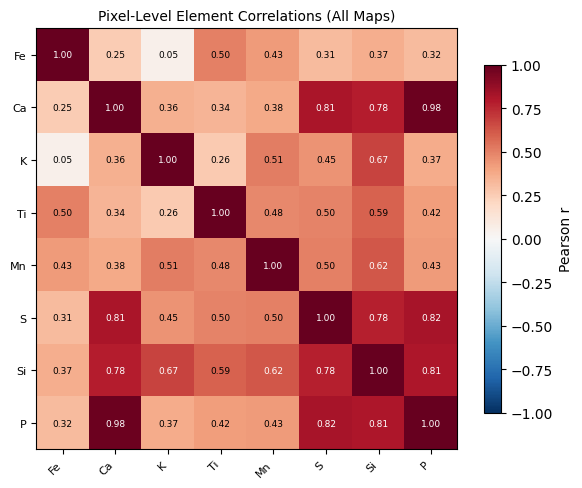

In [9]:
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(corr_matrix.values, cmap="RdBu_r", vmin=-1, vmax=1)
ax.set_xticks(range(len(ELEM_SHORT)))
ax.set_xticklabels(ELEM_SHORT, fontsize=8, rotation=45, ha="right")
ax.set_yticks(range(len(ELEM_SHORT)))
ax.set_yticklabels(ELEM_SHORT, fontsize=8)
for i in range(len(ELEM_SHORT)):
    for j in range(len(ELEM_SHORT)):
        val = corr_matrix.values[i, j]
        color = "white" if abs(val) > 0.6 else "black"
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=6.5, color=color)
plt.colorbar(im, ax=ax, label="Pearson r", shrink=0.8)
ax.set_title("Pixel-Level Element Correlations (All Maps)", fontsize=10)
fig.tight_layout()
plt.show()

## 3. Interactive: XANES point scatter by cluster
Select X and Y elements to plot correlations colored by cluster.

In [10]:
available_elements = [e for e in ELEM_SHORT if e in points_df.columns]

x_dropdown = widgets.Dropdown(options=available_elements, value="Fe", description="X element:")
y_dropdown = widgets.Dropdown(options=available_elements, value="Ca", description="Y element:")
output_scatter = widgets.Output()

def update_scatter(*args):
    with output_scatter:
        clear_output(wait=True)
        x_elem, y_elem = x_dropdown.value, y_dropdown.value
        if x_elem == y_elem:
            print("Select two different elements.")
            return

        fig, ax = plt.subplots(figsize=(6, 5))
        for c in sorted(points_df["cluster"].unique()):
            sub = points_df[points_df["cluster"] == c]
            ax.scatter(sub[x_elem], sub[y_elem], c=CLUSTER_COLORS[c],
                       label=CLUSTER_LABELS[c], s=25, alpha=0.7, edgecolors="none")

        valid = points_df[[x_elem, y_elem]].dropna()
        if len(valid) > 5:
            r, p = pearsonr(valid[x_elem], valid[y_elem])
            ax.set_title(f"{x_elem} vs {y_elem}  (r={r:.2f}, p={p:.3g})", fontsize=11)
        else:
            ax.set_title(f"{x_elem} vs {y_elem}", fontsize=11)

        ax.set_xlabel(f"{x_elem} K\u03b1 counts", fontsize=10)
        ax.set_ylabel(f"{y_elem} K\u03b1 counts", fontsize=10)
        ax.ticklabel_format(style='scientific', axis='both', scilimits=(0, 0))
        ax.legend(fontsize=8)
        fig.tight_layout()
        plt.show()

        # Per-cluster stats
        print(f"\n{'Cluster':<10} {'n':<5} {'Pearson r':<12} {'p-value':<12}")
        print("-" * 40)
        for c in sorted(points_df["cluster"].unique()):
            sub = points_df[points_df["cluster"] == c][[x_elem, y_elem]].dropna()
            if len(sub) >= 5:
                r, p = pearsonr(sub[x_elem], sub[y_elem])
                print(f"{c:<10} {len(sub):<5} {r:+.3f}{'*' if p < 0.05 else ' ':8s} {p:.4f}")

x_dropdown.observe(update_scatter, names='value')
y_dropdown.observe(update_scatter, names='value')

display(widgets.HBox([x_dropdown, y_dropdown]))
display(output_scatter)
update_scatter()

Output()

## 4. Interactive: Pixel-level density scatter (Figure 1 maps)
Select two elements to compare across the four Figure 1 maps.

In [11]:
# Elements available in per-map data
map_elements = sorted(set().union(*(d.keys() for d in map_pixel_data.values())))

mx_dropdown = widgets.Dropdown(options=map_elements, value="Fe", description="X element:")
my_dropdown = widgets.Dropdown(options=map_elements, value="Ca", description="Y element:")
output_density = widgets.Output()

def update_density(*args):
    with output_density:
        clear_output(wait=True)
        x_elem, y_elem = mx_dropdown.value, my_dropdown.value
        if x_elem == y_elem:
            print("Select two different elements.")
            return

        map_labels = [ml for ml in FIG1_MAPS if ml in map_pixel_data]
        n_maps = len(map_labels)
        fig, axes = plt.subplots(1, n_maps, figsize=(3.5 * n_maps, 3.2))
        if n_maps == 1:
            axes = [axes]

        for idx, map_label in enumerate(map_labels):
            ax = axes[idx]
            pdata = map_pixel_data[map_label]

            if x_elem not in pdata or y_elem not in pdata:
                ax.set_title(f"{map_label}\n(missing data)", fontsize=8)
                ax.axis("off")
                continue

            xd, yd = pdata[x_elem], pdata[y_elem]
            mask = (xd > 0) & (yd > 0)
            if mask.sum() < 10:
                ax.set_title(f"{map_label}\n(too few pixels)", fontsize=8)
                continue

            ax.hist2d(xd[mask], yd[mask], bins=80, cmap="inferno",
                      norm=LogNorm(), rasterized=True)

            r, _ = pearsonr(xd[mask], yd[mask])
            short_label = map_label.replace("_gt15", "").replace("_", " ")
            ax.set_title(f"{short_label}\nr={r:.2f}", fontsize=8)
            ax.tick_params(labelsize=6)
            ax.ticklabel_format(style='scientific', axis='both', scilimits=(0, 0))
            ax.xaxis.get_offset_text().set_fontsize(5)
            ax.yaxis.get_offset_text().set_fontsize(5)

            if idx == 0:
                ax.set_ylabel(f"{y_elem} K\u03b1 counts", fontsize=8)
            ax.set_xlabel(f"{x_elem} K\u03b1 counts", fontsize=8)

        fig.suptitle(f"Pixel-Level {x_elem} vs {y_elem} on Figure 1 Maps", fontsize=11)
        fig.tight_layout()
        plt.show()

mx_dropdown.observe(update_density, names='value')
my_dropdown.observe(update_density, names='value')

display(widgets.HBox([mx_dropdown, my_dropdown]))
display(output_density)
update_density()

Output()

## 5. Interactive: Cluster correlation bar chart
Select which elements to compare against a reference element.

In [12]:
all_corr_elements = sorted(cluster_corr_df["element"].unique())

ref_dropdown = widgets.Dropdown(options=available_elements, value="Fe", description="Reference:")
bar_select = widgets.SelectMultiple(
    options=[e for e in available_elements if e != "Fe"],
    value=["Ca", "K", "Ti", "Mn", "S"],
    description="Compare:",
    rows=7
)
output_bars = widgets.Output()

def update_bars(*args):
    with output_bars:
        clear_output(wait=True)
        ref = ref_dropdown.value
        targets = [e for e in bar_select.value if e != ref]
        if not targets:
            print("Select at least one comparison element.")
            return

        # Recompute correlations for the selected reference element
        bar_data = []
        for c in sorted(points_df["cluster"].unique()):
            sub = points_df[points_df["cluster"] == c]
            if len(sub) < 5:
                continue
            for e in targets:
                if e not in sub.columns or ref not in sub.columns:
                    continue
                valid = sub[[ref, e]].dropna()
                if len(valid) < 5:
                    continue
                r, p = pearsonr(valid[ref], valid[e])
                bar_data.append({"cluster": c, "element": e, "r": r, "p": p})

        if not bar_data:
            print("Not enough data for selected elements.")
            return

        bar_df = pd.DataFrame(bar_data)
        clusters = sorted(bar_df["cluster"].unique())

        fig, ax = plt.subplots(figsize=(max(6, 1.5 * len(targets)), 4.5))
        x = np.arange(len(targets))
        n_c = len(clusters)
        width = 0.8 / n_c

        for ci, c in enumerate(clusters):
            sub = bar_df[bar_df["cluster"] == c]
            vals = []
            for e in targets:
                row = sub[sub["element"] == e]
                vals.append(row["r"].values[0] if len(row) > 0 else 0)
            offset = (ci - n_c / 2 + 0.5) * width
            ax.bar(x + offset, vals, width, color=CLUSTER_COLORS[c],
                   label=CLUSTER_LABELS[c], edgecolor="white", linewidth=0.5)

        ax.set_xticks(x)
        ax.set_xticklabels([f"{ref} vs {e}" for e in targets], fontsize=9)
        ax.set_ylabel("Pearson r", fontsize=10)
        ax.set_title(f"{ref} Correlation with Other Elements by Cluster", fontsize=11)
        ax.axhline(y=0, color="black", lw=0.5)
        ax.legend(fontsize=8)
        ax.tick_params(labelsize=8)
        fig.tight_layout()
        plt.show()

ref_dropdown.observe(update_bars, names='value')
bar_select.observe(update_bars, names='value')

display(widgets.HBox([ref_dropdown, bar_select]))
display(output_bars)
update_bars()

Output()

## 6. Interactive: Ternary-style ratio plot
Select three elements for the ratio plot.

In [ ]:
t1_dropdown = widgets.Dropdown(options=available_elements, value="Fe", description="Element 1:")
t2_dropdown = widgets.Dropdown(options=available_elements, value="Ca", description="Element 2:")
t3_dropdown = widgets.Dropdown(options=available_elements, value="K", description="Element 3:")
output_ternary = widgets.Output()

def update_ternary(*args):
    with output_ternary:
        clear_output(wait=True)
        e1, e2, e3 = t1_dropdown.value, t2_dropdown.value, t3_dropdown.value
        if len({e1, e2, e3}) < 3:
            print("Select three different elements.")
            return

        fig, ax = plt.subplots(figsize=(6, 5))
        for c in sorted(points_df["cluster"].unique()):
            sub = points_df[points_df["cluster"] == c]
            if all(e in sub.columns for e in [e1, e2, e3]):
                total = sub[e1] + sub[e2] + sub[e3]
                frac1 = sub[e1] / total
                frac2 = sub[e2] / total
                ax.scatter(frac1, frac2, c=CLUSTER_COLORS[c],
                           label=CLUSTER_LABELS[c], s=25, alpha=0.7, edgecolors="none")

        ax.set_xlabel(f"{e1} / ({e1} + {e2} + {e3})", fontsize=10)
        ax.set_ylabel(f"{e2} / ({e1} + {e2} + {e3})", fontsize=10)
        ax.set_title(f"{e1}\u2013{e2}\u2013{e3} Composition at XANES Points", fontsize=11)
        ax.legend(fontsize=8)
        fig.tight_layout()
        plt.show()

t1_dropdown.observe(update_ternary, names='value')
t2_dropdown.observe(update_ternary, names='value')
t3_dropdown.observe(update_ternary, names='value')

display(widgets.HBox([t1_dropdown, t2_dropdown, t3_dropdown]))
display(output_ternary)
update_ternary()

Output()

## 7. Per-map correlation heatmaps

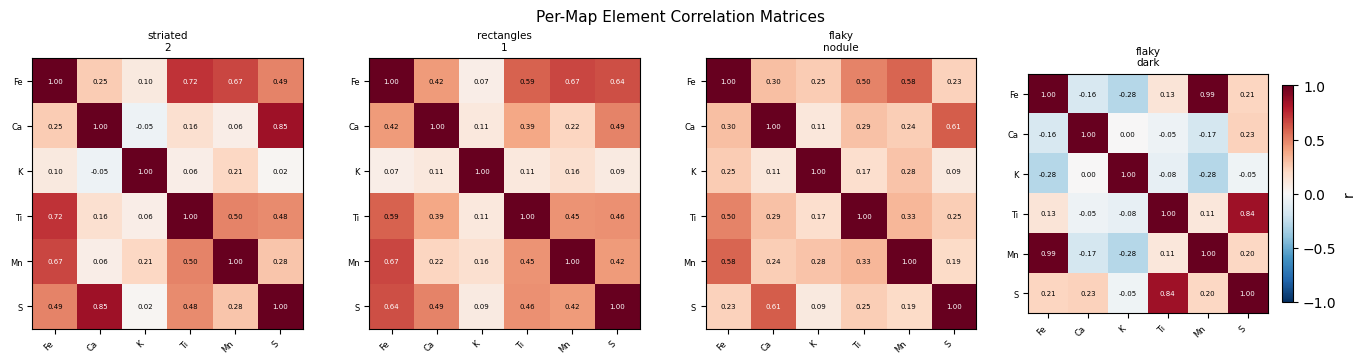

In [14]:
corr_elements = ["Fe", "Ca", "K", "Ti", "Mn", "S"]

fig, axes = plt.subplots(1, 4, figsize=(14, 3.5))

for idx, (map_label, h5_name) in enumerate(FIG1_MAPS.items()):
    ax = axes[idx]
    h5_path = MAP_DIR / h5_name
    with h5py.File(h5_path, "r") as f:
        map_data = {}
        for elem in ELEMENTS:
            m = get_roi_map(f, elem)
            if m is not None:
                map_data[SHORT[elem]] = m.ravel()

    avail = [e for e in corr_elements if e in map_data]
    df_local = pd.DataFrame({e: map_data[e] for e in avail})
    corr_local = df_local.corr()

    im = ax.imshow(corr_local.values, cmap="RdBu_r", vmin=-1, vmax=1)
    ax.set_xticks(range(len(avail)))
    ax.set_xticklabels(avail, fontsize=6, rotation=45, ha="right")
    ax.set_yticks(range(len(avail)))
    ax.set_yticklabels(avail, fontsize=6)
    for i in range(len(avail)):
        for j in range(len(avail)):
            val = corr_local.values[i, j]
            color = "white" if abs(val) > 0.6 else "black"
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=5, color=color)

    short_label = map_label.replace("_gt15", "").replace("_", "\n")
    ax.set_title(short_label, fontsize=7.5)

plt.colorbar(im, ax=axes[-1], label="r", shrink=0.8)
fig.suptitle("Per-Map Element Correlation Matrices", fontsize=11)
fig.tight_layout()
plt.show()

## 8. Summary

In [15]:
print("Pixel-level Fe correlations (all maps combined):")
for e in ELEM_SHORT:
    if e != "Fe":
        r = corr_matrix.loc["Fe", e]
        strength = "strong" if abs(r) > 0.5 else "moderate" if abs(r) > 0.3 else "weak"
        direction = "positive" if r > 0 else "negative"
        print(f"  Fe vs {e:3s}: r = {r:+.3f}  ({strength} {direction})")

print(f"\nCluster-specific Fe\u2013Ca correlation (XANES points):")
for c in sorted(points_df["cluster"].unique()):
    sub = points_df[points_df["cluster"] == c]
    if "Ca" in sub.columns and len(sub) > 5:
        valid = sub[["Fe", "Ca"]].dropna()
        r, p = pearsonr(valid["Fe"], valid["Ca"])
        print(f"  Cluster {c} (n={len(valid)}): r = {r:+.3f}, p = {p:.4f}")

Pixel-level Fe correlations (all maps combined):
  Fe vs Ca : r = +0.255  (weak positive)
  Fe vs K  : r = +0.054  (weak positive)
  Fe vs Ti : r = +0.505  (strong positive)
  Fe vs Mn : r = +0.428  (moderate positive)
  Fe vs S  : r = +0.313  (moderate positive)
  Fe vs Si : r = +0.366  (moderate positive)
  Fe vs P  : r = +0.316  (moderate positive)

Cluster-specific Fe–Ca correlation (XANES points):
  Cluster 1 (n=51): r = -0.347, p = 0.0125
  Cluster 2 (n=36): r = -0.102, p = 0.5541
  Cluster 3 (n=26): r = -0.335, p = 0.0948
  Cluster 4 (n=33): r = +0.188, p = 0.2942
  Cluster 5 (n=25): r = +0.218, p = 0.2959
